In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
import os
print(os.getcwd())


c:\Users\dprih\OneDrive\Dokumen\ITS\ITS Semester 6\Capstone-Bangkit-ML\forecasting\model


In [3]:
# Memuat data
data = pd.read_csv("C:\\Users\\dprih\\OneDrive\\Dokumen\\ITS\\ITS Semester 6\\Capstone-Bangkit-ML\\scrap-data-new\\new-scrap-mean\\kedelai_lokal_mean.csv")
data['tanggal'] = pd.to_datetime(data['tanggal'])
data.set_index('tanggal', inplace=True)
data

,no,hrg
tanggal,,
2023-01-01,0,10797.052632
2023-01-02,1,10781.921053
2023-01-03,2,10803.842105
2023-01-04,3,10797.263158
2023-01-05,4,10827.736842
...,...,...
2024-05-29,514,10991.710526
2024-05-30,515,10998.289474
2024-05-31,516,10987.763158


In [4]:
#Drop the no 
data = data.drop(columns=['no'])
data

,hrg
tanggal,
2023-01-01,10797.052632
2023-01-02,10781.921053
2023-01-03,10803.842105
2023-01-04,10797.263158
2023-01-05,10827.736842
...,...
2024-05-29,10991.710526
2024-05-30,10998.289474
2024-05-31,10987.763158


In [5]:
# Menormalisasi data harga
scaler = MinMaxScaler(feature_range=(0, 1))
data['hrg'] = scaler.fit_transform(data['hrg'].values.reshape(-1,1))

In [6]:
# Membuat dataset untuk LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
# Parameter
time_step = 10

In [8]:
# Membagi data menjadi train dan test
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:len(data)]

In [9]:
# Membuat dataset untuk train dan test
trainX, trainY = create_dataset(train.values, time_step)
testX, testY = create_dataset(test.values, time_step)

In [10]:
# Mengubah input menjadi [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

In [11]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Menampilkan ringkasan model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), loss=tf.keras.losses.Huber())

# Melatih model
model.fit(trainX, trainY, batch_size=1, epochs=20)

Epoch 1/20
404/404 [==============================] - 7s 7ms/step - loss: 0.0093
Epoch 2/20
404/404 [==============================] - 2s 6ms/step - loss: 0.0024
Epoch 3/20
404/404 [==============================] - 2s 6ms/step - loss: 0.0024
Epoch 4/20
404/404 [==============================] - 2s 5ms/step - loss: 0.0024
Epoch 5/20
404/404 [==============================] - 2s 5ms/step - loss: 0.0022
Epoch 6/20
404/404 [==============================] - 2s 5ms/step - loss: 0.0025
Epoch 7/20
404/404 [==============================] - 2s 5ms/step - loss: 0.0023
Epoch 8/20
404/404 [==============================] - 2s 6ms/step - loss: 0.0021
Epoch 9/20
404/404 [==============================] - 2s 5ms/step - loss: 0.0021
Epoch 10/20
404/404 [==============================] - 2s 5ms/step - loss: 0.0020
Epoch 11/20
404/404 [==============================] - 2s 5ms/step - loss: 0.0021
Epoch 12/20
404/404 [==============================] - 2s 5ms/step - loss: 0.0020
Epoch 13/20
404/404 [====

In [13]:
# Melakukan prediksi
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

3/3 [==============================] - 0s 3ms/step


In [14]:
# Mengembalikan harga ke skala semula
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

In [15]:
# Menghitung MAPE untuk train dan test
mape_train = mean_absolute_percentage_error(trainY, train_predict) * 100
mape_test = mean_absolute_percentage_error(testY, test_predict) * 100

print(f"MAPE Train: {mape_train}%")
print(f"MAPE Test: {mape_test}%")

MAPE Train: 0.33087869260818836%
MAPE Test: 0.41164516742206%


In [16]:

# Membuat dataframe untuk hasil prediksi train
train_predict_df = pd.DataFrame({
    'tanggal': data.index[time_step:len(train_predict) + time_step],
    'harga_asli': trainY.flatten(),
    'harga_prediksi': train_predict.flatten()
})
train_predict_df.set_index('tanggal', inplace=True)

# Membuat dataframe untuk hasil prediksi test
test_predict_df = pd.DataFrame({
    'tanggal': data.index[len(train_predict) + (time_step * 2) + 1:len(data) - 1],
    'harga_asli': testY.flatten(),
    'harga_prediksi': test_predict.flatten()
})
test_predict_df.set_index('tanggal', inplace=True)

# Menampilkan hasil prediksi train
print("Hasil Prediksi Train:")
print(train_predict_df.head())

# Menampilkan hasil prediksi test
print("Hasil Prediksi Test:")
print(test_predict_df.head())

Hasil Prediksi Train:
              harga_asli  harga_prediksi
tanggal                                 
2023-01-11  10863.289474    10785.340820
2023-01-12  10863.289474    10792.036133
2023-01-13  10863.289474    10801.122070
2023-01-14  10863.289474    10809.749023
2023-01-15  10860.000000    10818.032227
Hasil Prediksi Test:
              harga_asli  harga_prediksi
tanggal                                 
2024-03-01  10807.789474    10774.168945
2024-03-02  10807.789474    10778.585938
2024-03-03  10818.105263    10782.388672
2024-03-04  10813.710526    10786.629883
2024-03-05  10813.710526    10790.542969


In [17]:
# Prediksi harga masa depan
future_steps = 30  # jumlah langkah ke depan yang ingin diprediksi
last_sequence = data.values[-time_step:]  # ambil urutan terakhir dari data

future_predictions = []

for _ in range(future_steps):
    # Ubah bentuk input menjadi [samples, time steps, features]
    input_sequence = last_sequence.reshape((1, time_step, 1))
    next_prediction = model.predict(input_sequence)
    future_predictions.append(next_prediction[0, 0])
    
    # Perbarui urutan terakhir dengan menggeser ke kiri dan menambahkan prediksi terbaru
    last_sequence = np.append(last_sequence[1:], next_prediction)[-time_step:]

# Mengembalikan harga ke skala semula untuk prediksi masa depan
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Membuat tanggal untuk prediksi masa depan
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, inclusive='right')

# Membuat dataframe untuk hasil prediksi masa depan
future_predict_df = pd.DataFrame({
    'tanggal': future_dates,
    'harga_prediksi': future_predictions.flatten()
})
future_predict_df.set_index('tanggal', inplace=True)

# Menampilkan hasil prediksi masa depan
print("Hasil Prediksi Masa Depan:")
print(future_predict_df.head())

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 14ms/step
Hasil Prediksi Masa Depan:
            harga_prediksi
tanggal                   
2024-06-03    10947.963867
2024-06-04    10948.098633
2024-06-05    10944.638672
2024-06-06    10940.331055
2024-06-07    10934.717773


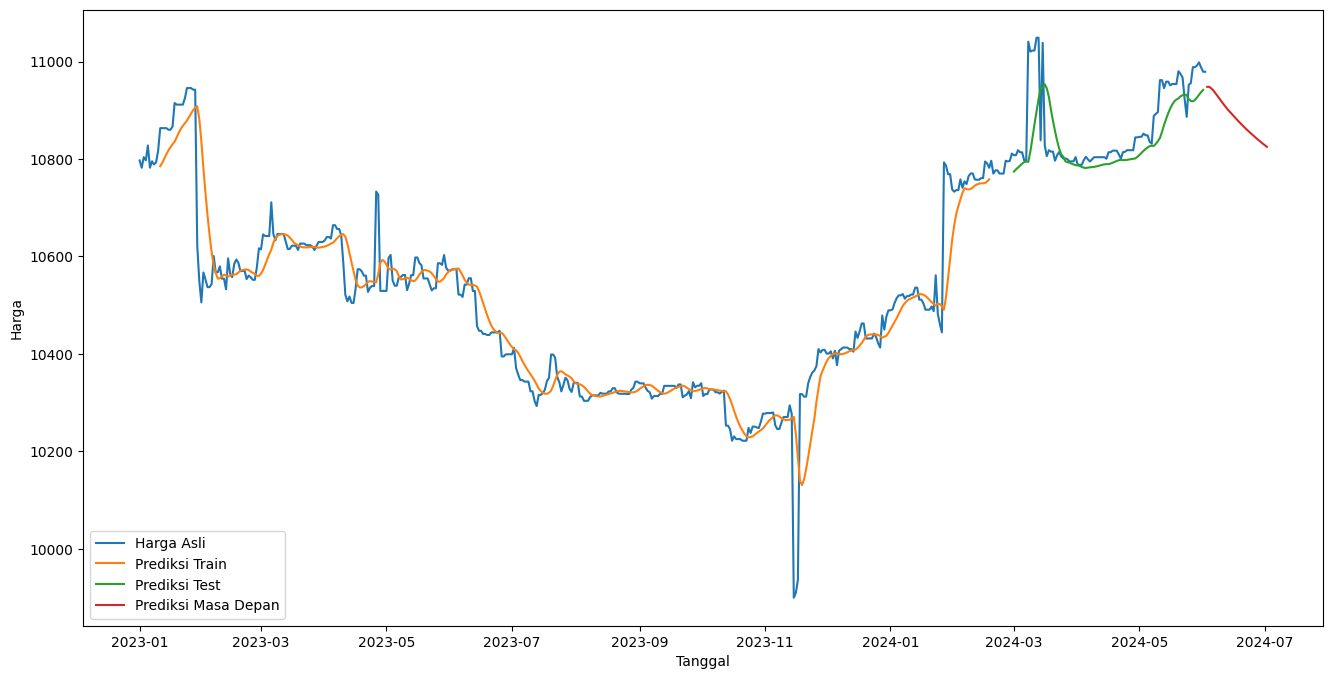

In [18]:
# Visualisasi hasil
plt.figure(figsize=(16,8))
plt.plot(data.index, scaler.inverse_transform(data['hrg'].values.reshape(-1, 1)), label='Harga Asli')
plt.plot(data.index[time_step:len(train_predict) + time_step], train_predict, label='Prediksi Train')
plt.plot(data.index[len(train_predict) + (time_step * 2) + 1:len(data) - 1], test_predict, label='Prediksi Test')
plt.plot(future_predict_df.index, future_predict_df['harga_prediksi'], label='Prediksi Masa Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.show()

## Saving the Model in Different Formats:
- Pickle

In [ ]:
import pickle

# Save the model using Pickle
with open('kedelai_forecasting.pkl', 'wb') as file:
    pickle.dump(model, file)

# Load the model using Pickle
with open('kedelai_forecasting.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

- H5

In [ ]:
# Save the model using H5 format
model.save('kedelai_forecasting.h5')

# Load the model using H5 format
from tensorflow.keras.models import load_model
loaded_model_h5 = load_model('kedelai_forecasting.h5')

- TensorFlow Saved Model

In [ ]:
# Save the model using TensorFlow SavedModel format
model.save('saved_model/kedelai_forecasting')

# Load the model using TensorFlow SavedModel format
loaded_model_saved = tf.keras.models.load_model('saved_model/kedelai_forecasting')

- TensorFlow Lite

In [ ]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('kedelai_forecasting.tflite', 'wb') as file:
    file.write(tflite_model)

# Load the TensorFlow Lite model (for inference, not training)
interpreter = tf.lite.Interpreter(model_path='kedelai_forecasting.tflite')
interpreter.allocate_tensors()

# Getting input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()